In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('FraudNLP_dataset.csv')
df.head()

,actions_str,actions,execution_time,Amount,type,is_fraud
0,/PROFILE/GETCUSTOMERRESPONSE /TAXFREE/GETTAXGO...,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...",203.0,13.0,CASH_OUT,0.0
1,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...",359.0,310.0,PAYMENT,0.0
2,/PROFILE/GETCUSTOMERRESPONSE /PROFILE/USERPROF...,"[22, 1, 29, 22, 26, 2, 23, 25, 6, 28, 14, 7, 6...",250.0,350.0,CASH_OUT,0.0
3,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 72, 1269, 1268, 1267, 4, 70, 46, ...",203.0,350.0,CASH_OUT,0.0
4,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 23, 2, 1269, 1269, 6, 25, 7, 28, ...",593.0,2000.0,CASH_IN,1.0


In [3]:
type_mapping = {
    'CASH_IN': 2,
    'CASH_OUT': 1,
    'PAYMENT': 3,
    'TRANSFER': 4,
    'DEBIT': 0
}

# Replace the values in the 'type' column based on the mapping
df['type'] = df['type'].replace(type_mapping)
df.head()

C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_2968\2756502279.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['type'] = df['type'].replace(type_mapping)


,actions_str,actions,execution_time,Amount,type,is_fraud
0,/PROFILE/GETCUSTOMERRESPONSE /TAXFREE/GETTAXGO...,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...",203.0,13.0,1.0,0.0
1,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...",359.0,310.0,3.0,0.0
2,/PROFILE/GETCUSTOMERRESPONSE /PROFILE/USERPROF...,"[22, 1, 29, 22, 26, 2, 23, 25, 6, 28, 14, 7, 6...",250.0,350.0,1.0,0.0
3,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 72, 1269, 1268, 1267, 4, 70, 46, ...",203.0,350.0,1.0,0.0
4,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 23, 2, 1269, 1269, 6, 25, 7, 28, ...",593.0,2000.0,2.0,1.0


In [4]:
df.dropna(inplace=True)
df.shape

(58973, 6)

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences

# Ensure you have the necessary NLTK resources
nltk.download('punkt')

# Load your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your data

def preprocess_text(text):
    segments = text.split('/')
    
    processed_segments = []
    for segment in segments:
        segment = segment.lower()  # Lowercase the text
        segment = re.sub(r'[^a-z\s]', '', segment)  # Remove non-alphabetical characters
        segment = re.sub(r'\s+', ' ', segment).strip()  # Remove extra spaces
        tokens = word_tokenize(segment)  # Tokenize the segment
        processed_segments.append(tokens)  # Append tokenized segments
    
    # Return the tokenized segments for each part split by '/'
    return processed_segments

# Apply the function to the DataFrame
df['processed_actions'] = df['actions_str'].apply(lambda x: preprocess_text(x))

# Flatten the processed actions to prepare for embedding
df['flattened_actions'] = df['processed_actions'].apply(lambda x: ' '.join([' '.join(segment) for segment in x]))

# Example: print the first 5 processed actions
print(df['flattened_actions'].head())

[nltk_data] Downloading package punkt to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     profile getcustomerresponse taxfree gettaxgoa...
1     profile getcustomerresponse campaign getbalan...
2     profile getcustomerresponse profile userprofi...
3     profile getcustomerresponse campaign getbalan...
4     profile getcustomerresponse campaign getbalan...
Name: flattened_actions, dtype: object


In [14]:
# Create a vocabulary from the GloVe embeddings
glove_file = open('glove.6B.100d.txt', encoding="utf8")
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Create a vocabulary length
vocab_length = len(embeddings_dictionary)

# Convert text into sequences of word indices
def text_to_sequence(text, embeddings_dict):
    return [embeddings_dict.get(word, np.zeros(100)) for word in text.split()] 

# Convert all processed action sequences into sequences of word indices
df['action_sequences'] = df['flattened_actions'].apply(lambda x: text_to_sequence(x, embeddings_dictionary))

# Example: print the first action sequences
print(df['action_sequences'].head())


0    [[-0.55668, 0.023938, -0.30828, -0.24503, 0.34...
1    [[-0.55668, 0.023938, -0.30828, -0.24503, 0.34...
2    [[-0.55668, 0.023938, -0.30828, -0.24503, 0.34...
3    [[-0.55668, 0.023938, -0.30828, -0.24503, 0.34...
4    [[-0.55668, 0.023938, -0.30828, -0.24503, 0.34...
Name: action_sequences, dtype: object


In [16]:
df.head()

,actions_str,actions,execution_time,Amount,type,is_fraud,processed_actions,flattened_actions,action_sequences
0,/PROFILE/GETCUSTOMERRESPONSE /TAXFREE/GETTAXGO...,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...",203.0,13.0,1.0,0.0,"[[], [profile], [getcustomerresponse], [taxfre...",profile getcustomerresponse taxfree gettaxgoa...,"[[-0.55668, 0.023938, -0.30828, -0.24503, 0.34..."
1,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...",359.0,310.0,3.0,0.0,"[[], [profile], [getcustomerresponse], [campai...",profile getcustomerresponse campaign getbalan...,"[[-0.55668, 0.023938, -0.30828, -0.24503, 0.34..."
2,/PROFILE/GETCUSTOMERRESPONSE /PROFILE/USERPROF...,"[22, 1, 29, 22, 26, 2, 23, 25, 6, 28, 14, 7, 6...",250.0,350.0,1.0,0.0,"[[], [profile], [getcustomerresponse], [profil...",profile getcustomerresponse profile userprofi...,"[[-0.55668, 0.023938, -0.30828, -0.24503, 0.34..."
3,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 72, 1269, 1268, 1267, 4, 70, 46, ...",203.0,350.0,1.0,0.0,"[[], [profile], [getcustomerresponse], [campai...",profile getcustomerresponse campaign getbalan...,"[[-0.55668, 0.023938, -0.30828, -0.24503, 0.34..."
4,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,"[22, 24, 27, 23, 2, 1269, 1269, 6, 25, 7, 28, ...",593.0,2000.0,2.0,1.0,"[[], [profile], [getcustomerresponse], [campai...",profile getcustomerresponse campaign getbalan...,"[[-0.55668, 0.023938, -0.30828, -0.24503, 0.34..."


In [18]:
# Pad the action sequences
max_sequence_length = 50  # Define a max length based on your data
padded_sequences = pad_sequences(df['action_sequences'].apply(lambda x: np.array(x)), maxlen=max_sequence_length, dtype='float32')

# Add the padded sequences to the DataFrame or store them for model input
df['padded_action_sequences'] = list(padded_sequences)

# Example: print the shape of the padded sequences
print(f"Padded sequences shape: {padded_sequences.shape}")


Padded sequences shape: (58973, 50, 100)


In [22]:
# Average the action sequences across the sequence length
X_action_sequences_flattened = np.array([np.mean(seq, axis=0) for seq in X_action_sequences])

# Now, X_action_sequences_flattened should be 2D with shape (num_samples, embedding_dimension)
print(f"Flattened Action Sequences shape: {X_action_sequences_flattened.shape}")


Flattened Action Sequences shape: (58973, 100)


In [36]:
# Combine features into a single input array
X = np.hstack((X_action_sequences_flattened, 
                X_execution_time.reshape(-1, 1), 
                X_amount.reshape(-1, 1), 
                X_type.reshape(-1, 1)))

# Extract labels
y = df['is_fraud'].values

# Example: check the shape of X and y
print(f"Feature shape: {X.shape}, Target shape: {y.shape}")


Feature shape: (58973, 103), Target shape: (58973,)


In [38]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Extract labels and convert to integer type
y = df['is_fraud'].values.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert y_train_resampled to integer type
y_train_resampled = y_train_resampled.astype(int)

# Check the distribution of the classes after SMOTE
print(f"New training target distribution: {np.bincount(y_train_resampled)}")


New training target distribution: [47097 47097]


In [46]:
# Padded Action Sequences
max_len = 10  # Adjust this based on your data
X_action_sequences_padded = pad_sequences(X_action_sequences_flattened, maxlen=max_len)

# Reshape other features to 3D
X_execution_time = X_execution_time.reshape(-1, 1)  # Shape: (num_samples, 1)
X_amount = X_amount.reshape(-1, 1)                    # Shape: (num_samples, 1)
X_type = X_type.reshape(-1, 1)                        # Shape: (num_samples, 1)

# Expand dimensions of other features to 3D
X_execution_time = np.expand_dims(X_execution_time, axis=1)  # Shape: (num_samples, 1, 1)
X_amount = np.expand_dims(X_amount, axis=1)                    # Shape: (num_samples, 1, 1)
X_type = np.expand_dims(X_type, axis=1)                        # Shape: (num_samples, 1, 1)

# Combine into a single 3D array
X_combined = np.concatenate((
    X_action_sequences_padded[..., np.newaxis],  # Shape: (num_samples, max_len, 1)
    X_execution_time,                             # Shape: (num_samples, 1, 1)
    X_amount,                                     # Shape: (num_samples, 1, 1)
    X_type                                        # Shape: (num_samples, 1, 1)
), axis=1)  # Concatenating along the time steps

# Now X_combined should have the correct shape
print(f"Feature shape for LSTM: {X_combined.shape}")

Feature shape for LSTM: (58973, 13, 1)


In [48]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

Training set shape: (47178, 13, 1), Validation set shape: (11795, 13, 1)


In [50]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

C:\Users\HP EliteBook\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 13, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.9923 - loss: 0.0382 - val_accuracy: 0.9988 - val_loss: 0.0092
Epoch 2/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9979 - loss: 0.0139 - val_accuracy: 0.9988 - val_loss: 0.0078
Epoch 3/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9981 - loss: 0.0123 - val_accuracy: 0.9988 - val_loss: 0.0075
Epoch 4/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9983 - loss: 0.0098 - val_accuracy: 0.9988 - val_loss: 0.0068
Epoch 5/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9980 - loss: 0.0102 - val_accuracy: 0.9988 - val_loss: 0.0094
Epoch 6/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9977 - loss: 0.0138 - val_accuracy: 0.9988 - val_loss: 0.0078
Epoch 7/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9982 - loss: 0.0111 - val_accuracy: 0.9988 - val_loss: 0.0077
Epoch 8/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9978 - loss: 0.0140 - 

In [53]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9990 - loss: 0.0067
Validation Loss: 0.007625020574778318, Validation Accuracy: 0.9988130331039429


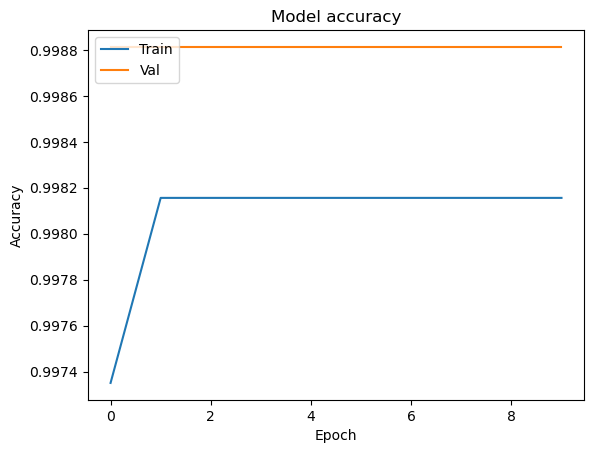

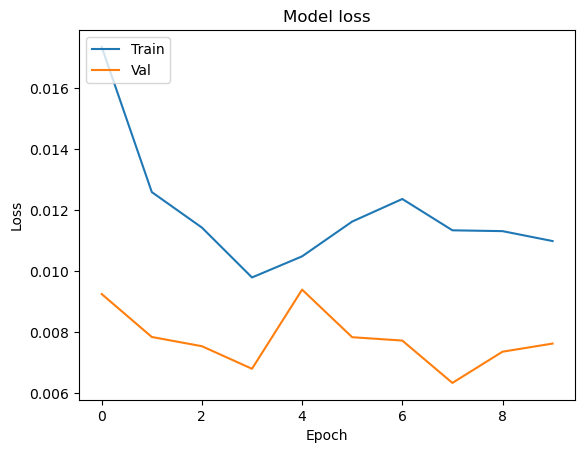

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [151]:
data = df.iloc[60]
data

actions_str                /P2P/LOYALTYUSERINFO /WEALTH/GETPORTFOLIOSLIST...
actions                    [93, 52, 7, 10, 12, 13, 4, 56, 19, 52, 8, 7, 7...
execution_time                                                         717.0
Amount                                                                 160.0
type                                                                     2.0
is_fraud                                                                 0.0
processed_actions          [[], [pp], [loyaltyuserinfo], [wealth], [getpo...
flattened_actions           pp loyaltyuserinfo wealth getportfolioslist t...
action_sequences           [[-0.42414, 0.043225, 0.38302, -0.56148, 0.385...
padded_action_sequences    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: 60, dtype: object

In [153]:
data = data[['actions_str','execution_time','Amount','type']]
data

actions_str       /P2P/LOYALTYUSERINFO /WEALTH/GETPORTFOLIOSLIST...
execution_time                                                717.0
Amount                                                        160.0
type                                                            2.0
Name: 60, dtype: object

In [155]:
def preprocess_text(text):
    segments = text.split('/')
    processed_segments = []
    for segment in segments:
        segment = segment.lower()  # Lowercase the text
        segment = re.sub(r'[^a-z\s]', '', segment)  # Remove non-alphabetical characters
        segment = re.sub(r'\s+', ' ', segment).strip()  # Remove extra spaces
        processed_segments.append(segment)  # Append processed segments
    return ' '.join(processed_segments)  # Join back to a single string

In [157]:
# Extract values from the DataFrame
action_text = df['actions_str'].values[0]
execution_time = df['execution_time'].values[0]
amount = df['Amount'].values[0]
action_type = df['type'].values[0]

In [159]:
import numpy as np
import re
from keras.preprocessing.sequence import pad_sequences

# Preprocess text function
def preprocess_text(text):
    segments = text.split('/')
    processed_segments = []
    for segment in segments:
        segment = segment.lower()  # Lowercase the text
        segment = re.sub(r'[^a-z\s]', '', segment)  # Remove non-alphabetical characters
        segment = re.sub(r'\s+', ' ', segment).strip()  # Remove extra spaces
        processed_segments.append(segment)  # Append processed segments
    return ' '.join(processed_segments)  # Join back to a single string

# Extract values from the DataFrame
data = df.iloc[1]  # Get the row as a Series
action_text = data['actions_str']  # Extract action text
execution_time = data['execution_time']  # Extract execution time
amount = data['Amount']  # Extract amount
action_type = data['type']  # Extract action type

# Preprocess the action text
processed_action_text = preprocess_text(action_text)

# Convert to sequence using the GloVe embeddings
def text_to_sequence(text, embeddings_dict):
    return [embeddings_dict.get(word, np.zeros(100)) for word in text.split()]  # Use zeros for unknown words

# Create action sequence
action_sequence = text_to_sequence(processed_action_text, embeddings_dictionary)

# Pad the action sequence
max_len = 10  # Adjust this based on your model's input requirements
action_sequence_padded = pad_sequences([action_sequence], maxlen=max_len)

# Reshape features to match the padded sequence dimensions
features = np.array([[execution_time, amount, action_type]])

# Reshape action_sequence_padded to ensure it has 2 dimensions
action_sequence_reshaped = action_sequence_padded.reshape(action_sequence_padded.shape[0], -1)

# Combine features into a single input array
combined_input = np.concatenate((action_sequence_reshaped, features), axis=1)

# Make prediction
predicted_class = model.predict(combined_input)

# Print the predicted class
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[[0.00697201]]


In [148]:
# Make prediction
predicted_probabilities = model.predict(combined_input)

# Convert probabilities to binary classification
predicted_class = (predicted_probabilities >= 0.5).astype(int)

# Print the predicted class
print(predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[[0]]


In [115]:
import mlflow
from mlflow.tracking import MlflowClient

In [105]:
import mlflow
import mlflow.keras
from sklearn.metrics import accuracy_score, classification_report

# Set up MLflow experiment
mlflow.set_experiment("Fraud Detection LSTM")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

2024/10/17 17:06:23 INFO mlflow.tracking.fluent: Experiment with name 'Fraud Detection LSTM' does not exist. Creating a new experiment.


In [111]:
# Access training and validation metrics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

In [117]:
with mlflow.start_run():
    
    # Log metrics
    mlflow.log_metrics({
    'final_training_loss': training_loss[-1],
    'final_validation_loss': validation_loss[-1],
    'final_training_accuracy': training_accuracy[-1],
    'final_validation_accuracy': validation_accuracy[-1]
    })
    
    # Log the LSTM model
    mlflow.keras.log_model(model, "LSTM_Model")  

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/LSTM_Model"  # Get the model URI
    client = MlflowClient()
    client.create_registered_model("FraudDetectionModel_LSTM")  # Give your model a name
    client.create_model_version("FraudDetectionModel_LSTM", model_uri, "1")  # Update version as needed

2024/10/17 17:10:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/17 17:10:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 17:10:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FraudDetectionModel_LSTM, version 1
2024/10/17 17:10:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-gull-302 at: http://127.0.0.1:5000/#/experiments/856958236460782812/runs/c0aff221bb714bd2ae1d9377e013fabd.
2024/10/17 17:10:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/856958236460782812.


In [119]:
import mlflow.pyfunc

# Load the model (use the correct model name and version)
loaded_model = mlflow.pyfunc.load_model("models:/FraudDetectionModel_LSTM/1")  



# Make predictions
predictions = loaded_model.predict(combined_input)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
[[0.00697201]]
